## Import

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import ast
import json
import seaborn as sn

## Gathering data
### Image predictions

In [2]:
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv').content 
image_predictions = pd.read_csv(io.StringIO(r.decode('utf-8')),sep='\t')
image_predictions.sample(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1779,828409743546925057,https://pbs.twimg.com/media/C38aQYgXAAMY2Wh.jpg,1,teddy,0.908457,False,toy_poodle,0.01804,True,standard_poodle,0.012667,True


### Twitter archive enhanced

In [3]:
twitter_enhanced=pd.read_csv('twitter-archive-enhanced.csv')
twitter_enhanced.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### QUALITY PROBLEMS

- data on column timestamp have +0000 we need to delete that caracters
- column tweet_id is int64, we require to change to string and column timestamp is an object
- 'tweet_id' and 'id_str' columns are the same, we need to remove one column
- we need to delete the retweets, we can look the retweeted_status_id column
- There are a lot of errors on ratings, we need to check them
- There are some columns to delete, they dont bring more information
- We are going to delete rows with no Image predictions
- The tweet id 670842764863652 its snoop dog, we need to delete that row

### TIDY PROBLEMS

- merging the three data sets in one
- combining the columns doggo, puppo, pupper, floofer into a single column

#### Lets first merging the three data sets on DF, then im going to solve the quality problems and finally combining the 2nd tidy problem

In [4]:
tdata=[]
file=open('tweet-json.txt')
for lin in file:
    tdata.append(json.loads(lin))
df_twit_json=pd.DataFrame(data=tdata)
df_twit_json.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

##### Lets merge df_twit_json with twitter_enhanced, so first im going to change the column name in df_twit_json, id to tweet_id, just like in the twitter_enhanced dataframe.

In [5]:
df_twit_json.rename(columns={'id': 'tweet_id'}, inplace=True)
df_twit_json_to_merge=df_twit_json[['tweet_id','favorite_count','retweet_count','id_str']].copy()
df=pd.merge(left=twitter_enhanced,right=df_twit_json_to_merge, how='left', left_on='tweet_id',right_on='tweet_id')
df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,id_str
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,39467.0,8853.0,892420643555336193


#### Now lets merge with the Image predictions

In [6]:
df=pd.merge(left=df,right=image_predictions, how='left', left_on='tweet_id',right_on='tweet_id')

In [7]:
df.columns
df.to_excel("df_full.xlsx")

## Assesing Data

### Just for remember
##### Completeness: do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?
##### Validity: we have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
##### Accuracy: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty.
##### Consistency: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

In [9]:
df.favorite_count.isna().sum()

2

In [10]:
df.p1.isna().sum()

281

In [11]:
df.expanded_urls.duplicated().sum()

137

In [12]:
df.rating_numerator.sort_values(ascending=False)

979     1776
313      960
189      666
188      420
2074     420
1120     204
290      182
902      165
1779     144
1634     143
1635     121
1228      99
1843      88
433       84
1254      80
695       75
340       75
1351      60
1202      50
1274      45
1433      44
763       27
1712      26
516       24
1663      20
55        17
285       15
291       15
83        14
866       14
        ... 
2183       3
1314       3
1928       3
765        3
2202       3
1692       3
1478       3
1898       3
1249       3
2305       3
2079       2
2326       2
2349       2
2237       2
2246       2
1920       2
1761       2
2310       2
1764       2
1940       1
2038       1
2091       1
1869       1
1446       1
605        1
2338       1
2261       1
2335       1
1016       0
315        0
Name: rating_numerator, Length: 2356, dtype: int64

# Cleaning Data

### Quality

##### 1 Define: data on column timestamp have +0000 we need to delete that caracters

##### 1 Code:

In [13]:
df=df
df.timestamp=df.timestamp.astype('str')
df.timestamp = df.timestamp.map(lambda x: str(x)[:-6])

##### 1 Test:

In [14]:
df.timestamp.sample(2)

1593    2016-01-11 03:17:53
1632    2016-01-05 19:42:51
Name: timestamp, dtype: object

##### 2 Define: column tweet_id is int64, we require to change to string and column timestamp is an object

##### 2Code:

In [15]:
df.tweet_id=df.tweet_id.astype('str')
df.timestamp = pd.to_datetime(df['timestamp'])

##### 2 Test:

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count         

##### 3 Define: tweet_id' and 'id_str' columns are the same, we need to remove one column

##### 3 Code:

In [17]:
df.drop(columns =["id_str"], inplace = True)

##### 3 Test:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count         

##### 4 Define: We need to delete the retweets, we can look the retweeted_status_id column, and then delete it, they going to be empty.

##### 4 Code:

In [19]:
print('Nan count: ',df.retweeted_status_id.isna().sum())
print('df old shape: ',df.shape)
df=df[df['retweeted_status_id'].isnull()]
print('Nan count after delete retweets: ',df.retweeted_status_id.isna().sum())
print('df new shape: ',df.shape)

Nan count:  2175
df old shape:  (2356, 30)
Nan count after delete retweets:  2175
df new shape:  (2175, 30)


##### 4 Test:

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
favorite_count               

##### 5 Define: There are some columns to delete, they dont bring more information (in_reply_to_status_id, in_reply_to_user_id,source,retweeted_status_id, retweeted_status_user_id retweeted_status_timestamp)

##### 5 Code:

In [21]:
df.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id','source','retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'],inplace=True)


##### 5 Test:

In [22]:
print('df new shape: ',df.shape)

df new shape:  (2175, 24)


##### 6 Define: We are going to delete rows with no Image predictions

##### 6 Code:

In [23]:
df.dropna(subset=['jpg_url'],inplace=True)

##### 6 Test:

In [24]:
print('df new shape: ',df.shape)
print('null values: ',df.jpg_url.isna().sum())

df new shape:  (1994, 24)
null values:  0


##### 7 Define: There are errors on ratings, E.g. wrong data rating, 5 and it should be 13.5

##### 7 Code:

In [25]:
df2=df.copy()
pd.set_option("display.max_colwidth", -1)
df2['data_to_extract']=df2['text'].str.extract(pat ='(([\d]*[/][1][0])|([^.a-z][\d]*[.][\d]*[/][\d]*)|([\d]+[/][\d]*))')[0]
df2.data_to_extract=df2.data_to_extract.astype('str')
df2['data_to_extract'].replace(' ','', inplace=True)
#df2[['data_to_extract','rating_numerator','text']].sort_values(by='data_to_extract')

numbers=df2["data_to_extract"].str.split("/", n = 0, expand = True)
df2['rating_numerator_v2']=numbers[0]
df2['rating_denominator_v2']=numbers[1]

df2.rating_numerator_v2=df2.rating_numerator_v2.astype('float')
df2.rating_denominator_v2=df2.rating_denominator_v2.astype('int')

df2.drop(columns =["data_to_extract",'rating_numerator','rating_denominator'], inplace = True)

df=df2.copy()

In [26]:
df.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'name', 'doggo',
       'floofer', 'pupper', 'puppo', 'favorite_count', 'retweet_count',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'rating_numerator_v2',
       'rating_denominator_v2'],
      dtype='object')

##### 7 Test:

In [27]:
df.rating_numerator_v2.value_counts()

12.00      450
10.00      419
11.00      396
13.00      261
9.00       151
8.00       95 
7.00       52 
14.00      35 
5.00       32 
6.00       32 
3.00       19 
4.00       16 
2.00       9  
1.00       5  
0.00       2  
24.00      1  
9.75       1  
84.00      1  
13.50      1  
143.00     1  
420.00     1  
50.00      1  
80.00      1  
45.00      1  
60.00      1  
44.00      1  
144.00     1  
88.00      1  
11.26      1  
165.00     1  
11.27      1  
1776.00    1  
99.00      1  
121.00     1  
204.00     1  
Name: rating_numerator_v2, dtype: int64

##### 8 Define: the tweet id 670842764863652 its snoop dog, we need to delete that row i will use the 'https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg' link to find it.

##### 8 Code:

In [28]:
df.query("rating_numerator_v2==420")
print(df.shape)
df = df[df.jpg_url != 'https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg']
print(df.shape)

(1994, 24)
(1993, 24)


##### 8 Test:

In [29]:
print('New shape with no snoop dog row: ',df.shape)

New shape with no snoop dog row:  (1993, 24)


# Cleaning Data

### TIDY 2nd part: combining the columns doggo, puppo, pupper, floofer into a single column

In [30]:
df.columns
df2=df
df2.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'name', 'doggo',
       'floofer', 'pupper', 'puppo', 'favorite_count', 'retweet_count',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'rating_numerator_v2',
       'rating_denominator_v2'],
      dtype='object')

In [31]:
df2['doggo'].replace(to_replace='None', value='', inplace=True)
df2['floofer'].replace(to_replace='None', value='', inplace=True)
df2['pupper'].replace(to_replace='None', value='', inplace=True)
df2['puppo'].replace(to_replace='None', value='', inplace=True)

In [32]:
df2['stage_dog']=df2['doggo'].map(str)+df2['floofer'].map(str)+df2['pupper'].map(str)+df2['puppo'].map(str)

In [33]:
df2.stage_dog.value_counts()

                1687
pupper          203 
doggo           63  
puppo           22  
doggopupper     9   
floofer         7   
doggofloofer    1   
doggopuppo      1   
Name: stage_dog, dtype: int64

In [34]:
df2.reset_index(inplace=True)

In [35]:
df2.query('stage_dog=="doggopupper"')[['tweet_id','text','stage_dog']]

,tweet_id,text,stage_dog
340,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",doggopupper
397,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggopupper
419,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",doggopupper
425,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggopupper
510,785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,doggopupper
652,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",doggopupper
704,751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,doggopupper
795,741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggopupper
841,733109485275860992,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggopupper


In [36]:
df2.iloc[340, df.columns.get_loc('stage_dog')]='pupper'
df2.iloc[397, df.columns.get_loc('stage_dog')]='pupper/doggo'
df2.iloc[419, df.columns.get_loc('stage_dog')]='pupper/doggo'
df2.iloc[425, df.columns.get_loc('stage_dog')]='pupper/doggo'
df2.iloc[510, df.columns.get_loc('stage_dog')]='doggo'
df2.iloc[652, df.columns.get_loc('stage_dog')]='pupper/doggo'
df2.iloc[704, df.columns.get_loc('stage_dog')]='doggo'
df2.iloc[795, df.columns.get_loc('stage_dog')]='pupper/doggo'
df2.iloc[841, df.columns.get_loc('stage_dog')]='pupper/doggo'

In [37]:
df2.query('stage_dog=="doggofloofer"')[['tweet_id','text','stage_dog']]

,tweet_id,text,stage_dog
154,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggofloofer


In [38]:
df2.iloc[154, df.columns.get_loc('stage_dog')]='doggo'

In [39]:
df2.query('stage_dog=="doggopuppo"')[['tweet_id','text','stage_dog']]

,tweet_id,text,stage_dog
148,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,doggopuppo


In [40]:
df2.iloc[148, df.columns.get_loc('stage_dog')]='puppo'

In [41]:
df2.stage_dog.value_counts()

                1687
pupper          204 
doggo           66  
puppo           23  
floofer         7   
pupper/doggo    6   
Name: stage_dog, dtype: int64

In [42]:
df2.columns

Index(['index', 'tweet_id', 'timestamp', 'text', 'expanded_urls', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'favorite_count',
       'retweet_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'rating_numerator_v2',
       'rating_denominator_v2', 'stage_dog'],
      dtype='object')

In [43]:
df2.drop(columns =['doggo','floofer','pupper','puppo'], inplace = True)


In [44]:
df=df2

# Traspasing to CSV

In [ ]:
df.to_csv('twitter_archive_master.csv',index=False)

#  Analyze and visualize

Text(0.5,0,'breed of dog')

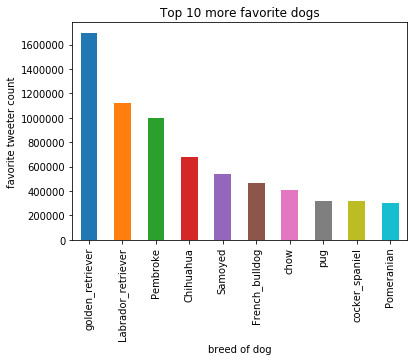

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
df.groupby(by=["p1"])['favorite_count'].sum().sort_values(ascending=False).head(10).plot(kind='bar',title='Top 10 more favorite dogs')
plt.ylabel('favorite tweeter count')
plt.xlabel('breed of dog')

In [47]:
print(df.groupby(by=['stage_dog'])['retweet_count'].describe())



               count         mean           std     min      25%     50%  \
stage_dog                                                                  
              1687.0  2576.922347  3936.508718   16.0    584.50   1302.0   
doggo         66.0    6911.787879  12608.600246  725.0   2017.25  3227.5   
floofer       7.0     4968.714286  6163.579715   496.0   1825.00  3265.0   
pupper        204.0   2367.112745  3562.887371   103.0   687.50   1207.0   
pupper/doggo  6.0     4973.500000  6228.125745   1573.0  2237.00  2477.0   
puppo         23.0    7027.086957  10408.775240  716.0   1721.00  3220.0   

                  75%      max  
stage_dog                       
              3069.00  56625.0  
doggo         5191.00  79515.0  
floofer       4436.50  18497.0  
pupper        2478.50  32883.0  
pupper/doggo  3271.25  17621.0  
puppo         7541.50  48265.0  


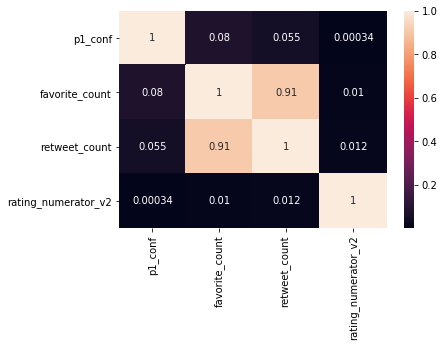

In [48]:
corr=pd.DataFrame(df,columns=['p1_conf','favorite_count','retweet_count','rating_numerator_v2'])
corrMat = corr.corr()
sn.heatmap(corrMat, annot=True)


In [49]:
!pip install nltk
import nltk
nltk.download([
     "names",
     "stopwords",
     "state_union",
     "twitter_samples",
     "movie_reviews",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ])

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [50]:
tweets=df['text']
df_tweets = pd.DataFrame({'tweets':tweets})
df_tweets['sentiment'] = df_tweets['tweets'].apply(lambda x: sia.polarity_scores(x)['compound'])

Text(0.5,0,'-1 Negative/Neutral\\Positive +1')

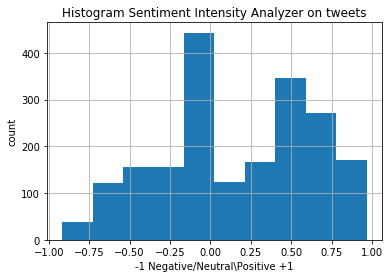

In [51]:
import matplotlib.pyplot as plt

df_tweets['sentiment'].hist()
plt.ylabel('count')
plt.title('Histogram Sentiment Intensity Analyzer on tweets')
plt.xlabel('-1 Negative/Neutral\Positive +1')

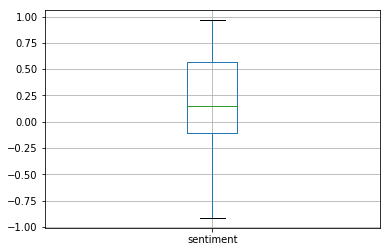

In [52]:
df_tweets.boxplot('sentiment')

In [53]:
df_tweets.sample(5)

,tweets,sentiment
1501,This is Lenny. He was just told that he couldn't explore the fish tank. 12/10 smh all that work for nothing https://t.co/JWi6YrpiO1,-0.3182
132,Meet Milky. She has no idea what happened. Just as pupset as you. Perhaps a sheep exploded. Even offered to help clean. 12/10 very good girl https://t.co/g8vpXFzw29,0.7501
1693,This is Charlie. He was just informed that dogs can't be Jedi. 11/10 https://t.co/mGW5c50mPA,0.0000
1193,Say hello to Leo. He's a Fallopian Puffalope. Precious af. 12/10 would cuddle https://t.co/LZEi0DpRsH,0.5719
680,Here's a frustrated pupper attempting to escape a pool of Frosted Flakes. 12/10 https://t.co/GAYViEweWr,-0.4019
